## GNN

### Подготовка к работе

In [2]:
! pip install biopandas torch_geometric
! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git@dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:0000:01
  Cloning https://github.com/rimgro/biocadprotein.git (to revision dev) to /tmp/pip-req-build-i87lijap
  Running command git clone --filter=blob:none --quiet https://github.com/rimgro/biocadprotein.git /tmp/pip-req-build-i87lijap
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/rimgro/biocadprotein.git to commit a71910904f4760f3aa22073ccbb905913ce99ac8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/evolutionaryscale/esm.git to /tmp/pip-install-6yizam5m/esm_7cbb3ce8921a493e99988898782f743a
  Running co

In [50]:
import numpy as np
import torch
from biopandas.pdb import PandasPdb
from itertools import combinations
from torch_geometric.data import Data

from fpgen.prop_prediction.dataset import FPbase

### Подготовка данных

In [98]:
def pdb_to_pyg_graph(pdb_file: str, target: float, distance_threshold: float = 5.0) -> Data:
    ppdb = PandasPdb().read_pdb(pdb_file)
    atoms = ppdb.df['ATOM']

    # Группировка атомов по остатку (chain_id, residue_number)
    atoms['res_id'] = atoms['chain_id'].astype(str) + "_" + atoms['residue_number'].astype(str)
    residue_groups = atoms.groupby('res_id')

    residues = list(residue_groups.groups.keys())
    num_nodes = len(residues)

    # Собираем координаты и имена остатков
    residue_coords = []
    residue_names = []

    for res_id in residues:
        group = residue_groups.get_group(res_id)
        coords = group[['x_coord', 'y_coord', 'z_coord']].values
        residue_coords.append(coords)
        residue_names.append(group['residue_name'].values[0])  # Одно имя на остаток

    # One-hot кодировка аминокислот
    aa_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
               'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
               'TYR', 'VAL']
    aa_to_idx = {aa: i for i, aa in enumerate(aa_list)}
    aa_indices = [aa_to_idx.get(res, len(aa_list)) for res in residue_names]
    one_hot = np.zeros((num_nodes, len(aa_list)+1))  # +1 для unknown
    one_hot[np.arange(num_nodes), aa_indices] = 1

    # В качестве координат узла можно взять центр масс или просто среднее
    centers = np.array([coords.mean(axis=0) for coords in residue_coords])

    # Узловые признаки: средние координаты + one-hot кодировка
    x = torch.tensor(np.concatenate([centers, one_hot], axis=1), dtype=torch.float)

    # Построение рёбер: расстояние между всеми парами остатков по минимальному расстоянию между атомами
    edge_index = []
    edge_attr = []

    for i, j in combinations(range(num_nodes), 2):
        coords_i = residue_coords[i]
        coords_j = residue_coords[j]

        dists = np.linalg.norm(coords_i[:, None, :] - coords_j[None, :, :], axis=2)
        min_dist = np.min(dists)

        if min_dist <= distance_threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])
            edge_attr.append([min_dist])
            edge_attr.append([min_dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [99]:
graph = pdb_to_pyg_graph("/kaggle/input/fpbase-structures/pdb_active_sites/radius_8/11G2Y.pdb", 1.843934)
graph.get_edge_index

<bound method GraphStore.get_edge_index of Data(x=[138, 24], edge_index=[2, 1242], edge_attr=[1242, 1], y=[1])>

In [100]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_pyg_graph(data, dim=2, node_label_attr='residue_name'):
    # Преобразуем PyG Data в NetworkX граф
    G = to_networkx(data, to_undirected=True)

    # Координаты узлов для отрисовки
    if dim == 2:
        pos = {i: (data.x[i][0].item(), data.x[i][1].item()) for i in range(data.num_nodes)}
    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for i, (xi, yi, zi) in enumerate(data.x[:, :3]):
            ax.scatter(xi, yi, zi, color='skyblue')
            ax.text(xi, yi, zi, str(i), size=6)
        for i, j in data.edge_index.T:
            xi, yi, zi = data.x[i][:3]
            xj, yj, zj = data.x[j][:3]
            ax.plot([xi, xj], [yi, yj], [zi, zj], color='gray', alpha=0.5)
        ax.set_title(f"3D Graph: {getattr(data, 'protein_name', '')}")
        plt.show()
        return

    # 2D-граф через networkx
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color='lightblue', edge_color='gray', with_labels=False, node_size=300)
    plt.title(f"2D Projection of Graph: {getattr(data, 'protein_name', '')}")
    plt.show()

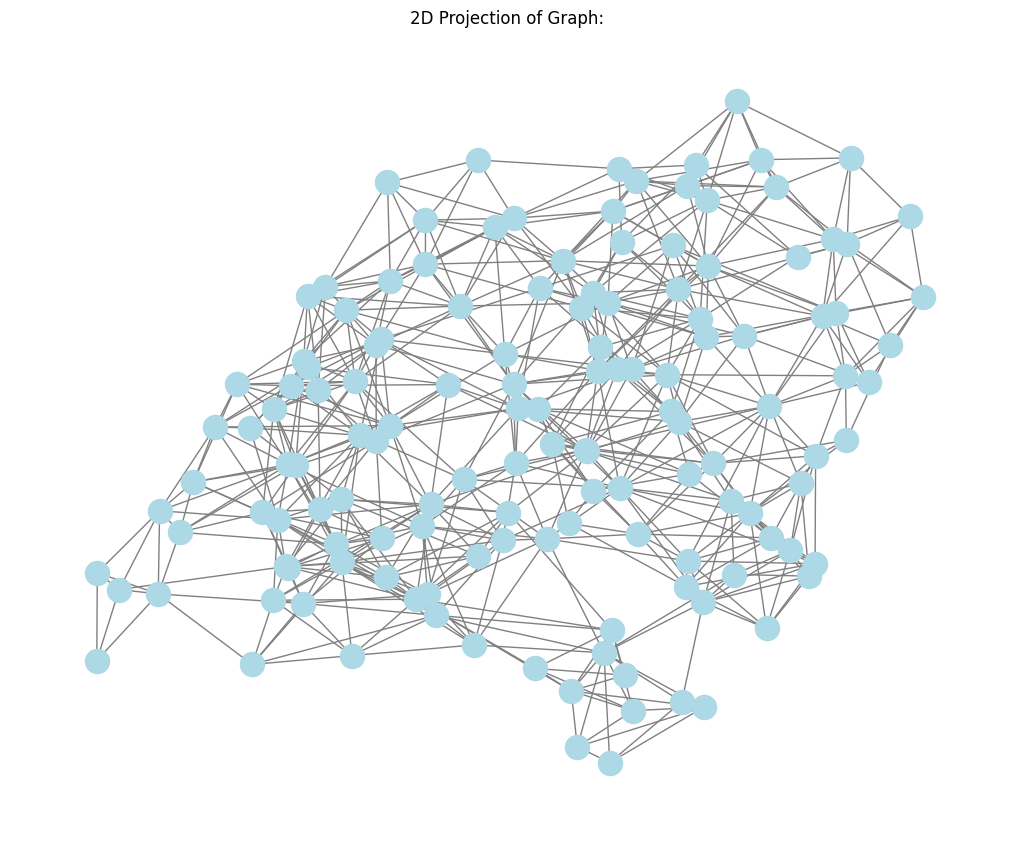

In [101]:
visualize_pyg_graph(graph)

In [131]:
from fpgen.prop_prediction.dataset import FPbase

In [132]:
dataset = FPbase('/kaggle/input/fpbase-structures/fpbase.csv')

In [133]:
x_train, y_train = dataset.get_train('em_max', additional_feature_columns=['id'])
x_test, y_test = dataset.get_test('em_max', additional_feature_columns=['id'])

In [134]:
path = '/kaggle/input/fpbase-structures/pdb_active_sites/radius_8/'

def preprocessing_dataset(x, y):
    graph = []
    for i in range(len(x)):
        id = x.iloc[i]['id']
        if id != '7XHKJ':
            g = pdb_to_pyg_graph(f'{path}{id}.pdb', y[i])
            graph.append(g)
    return graph

In [135]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(preprocessing_dataset(x_train, y_train), test_size=0.2, random_state=52)
test = preprocessing_dataset(x_test, y_test)

In [136]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=False)
val_loader = DataLoader(val, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Архитектура модели

In [116]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, Sequential, ReLU
from torch_geometric.nn import MessagePassing, global_add_pool
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.data import Data
from torch_geometric.utils import scatter

class MPLayer(MessagePassing):
    def __init__(self, mlp, edge_dim: int = 1):
        super().__init__(aggr='add')
        self.mlp = mlp
        if edge_dim != mlp[0].in_features:
            self.edge_embed = Linear(edge_dim, mlp[0].in_features)
        else:
            self.edge_embed = None
        
    def forward(self, x, edge_index=None, edge_attr=None):
        no_edges = (
            edge_index is None or 
            edge_index.dim() != 2 or 
            edge_index.size(1) == 0 or 
            edge_attr is None
        )

        if no_edges:
            return self.mlp(x)

        if self.edge_embed is not None:
            edge_emb = self.edge_embed(edge_attr)
        else:
            edge_emb = edge_attr.unsqueeze(-1) if edge_attr.dim() == 1 else edge_attr

        return self.propagate(edge_index, x=x, edge_emb=edge_emb)

    def message(self, x_j, edge_emb):
        return F.relu(x_j + edge_emb)

    def update(self, aggr_out, x):
        return self.mlp(x + aggr_out)

class GNN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4,
                 edge_dim: int = 1):  # edge_dim — размерность признаков рёбер
        super().__init__()

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = ModuleList()
        self.norms = ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )
            conv = MPLayer(mlp, edge_dim=edge_dim)
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim))

        self.head = Sequential(
            Linear(hidden_dim, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)
        )

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.node_embed(x)

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            x = F.relu(x)

        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)
        return out.squeeze(-1)

In [115]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, Sequential, ReLU
from torch_geometric.nn import GATConv, global_add_pool
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops


class GAT(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4,
                 heads: int = 4,
                 edge_dim: int = None):  # GATConv может использовать edge_attr при edge_dim
        super().__init__()

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = ModuleList()
        self.norms = ModuleList()

        for i in range(num_layers):
            in_dim = hidden_dim * heads if i > 0 else hidden_dim
            conv = GATConv(
                in_channels=in_dim,
                out_channels=hidden_dim,
                heads=heads,
                concat=True,
                edge_dim=edge_dim if edge_dim is not None else None,
                fill_value=0.0  # значение по умолчанию, если edge_attr нет
            )
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim * heads))

        self.head = Sequential(
            Linear(hidden_dim * heads, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)
        )

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        if edge_attr is not None and edge_attr.size(0) != edge_index.size(1):
            edge_attr = None  # Игнорируем некорректный edge_attr
    
        # Удалим self-loops
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
    
        # Приводим edge_attr к [E, edge_dim]
        if edge_attr is not None and edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(-1)
    
        x = self.node_embed(x)
    
        for conv, norm in zip(self.convs, self.norms):
            if edge_attr is not None:
                x = conv(x, edge_index, edge_attr)
            else:
                fake_attr = torch.zeros(edge_index.size(1), 1, device=x.device)
                x = conv(x, edge_index, fake_attr)
            x = norm(x)
            x = F.relu(x)
    
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)
        return out.squeeze(-1)

    


In [137]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, Sequential, ReLU
from torch_geometric.nn import GINEConv, global_add_pool
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.data import Data

class GNN(torch.nn.Module):
    """
    GNN для предсказания одного спектрального параметра
    (например, brightness) по структуре белка.
    """
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4):
        super().__init__()

        self.num_gaussians = 32
        self.register_buffer('offsets', torch.linspace(0, 10, self.num_gaussians))
        self.register_buffer('widths', torch.full((self.num_gaussians,), 0.5))

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = ModuleList()
        self.norms = ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )
            conv = GINEConv(mlp, edge_dim=self.num_gaussians)
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim))

        # Один выходной нейрон — регрессия
        self.head = Sequential(
            Linear(hidden_dim, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)  # ⬅️ только один выход
        )

    def gaussian_smearing(self, distances: torch.Tensor) -> torch.Tensor:
        diff = distances.unsqueeze(1) - self.offsets.unsqueeze(0)
        return torch.exp(-0.5 * (diff / self.widths.unsqueeze(0)) ** 2)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.squeeze()
        x = self.node_embed(x)
        edge_emb = self.gaussian_smearing(edge_attr)

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_emb)
            x = norm(x)
            x = F.relu(x)

        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)  # [batch_size, 1]
        return out.squeeze(-1)  # ⬅️ делаем [batch_size] для удобства

### Обучение модели

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN(in_channels=24).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()  # так как регрессия

In [139]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        '''
        print("x:", data.x.shape)
        print("y:", data.y.shape)
        print("batch:", data.batch.shape)
        '''
        target = data.y.view(-1)

        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)  # data.y: [batch_size]

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [140]:
def evaluate(model, loader, return_preds=False):
    model.eval()
    total_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            target = data.y.squeeze()

            loss = loss_fn(out, target)
            total_loss += loss.item()

            if return_preds:
                preds.append(out.cpu())
                targets.append(target.cpu())

    if return_preds:
        y_pred = torch.cat(preds, dim=0)
        y_true = torch.cat(targets, dim=0)
        return y_pred, y_true  # ✅ возвращаем два значения

    return total_loss / len(loader)


In [141]:
from tqdm import tqdm

best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(100)):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:53,  1.85it/s]

Epoch 0 | Train Loss: 3.0830 | Val Loss: 1.5999


  2%|▏         | 2/100 [00:01<00:51,  1.92it/s]

Epoch 1 | Train Loss: 1.5002 | Val Loss: 1.3255


  3%|▎         | 3/100 [00:01<00:49,  1.95it/s]

Epoch 2 | Train Loss: 1.0510 | Val Loss: 0.8977


  4%|▍         | 4/100 [00:02<00:48,  1.99it/s]

Epoch 3 | Train Loss: 0.9442 | Val Loss: 1.0693


  5%|▌         | 5/100 [00:02<00:47,  2.00it/s]

Epoch 4 | Train Loss: 0.8351 | Val Loss: 0.9871


  6%|▌         | 6/100 [00:03<00:47,  2.00it/s]

Epoch 5 | Train Loss: 0.7698 | Val Loss: 1.0767


  7%|▋         | 7/100 [00:03<00:46,  1.99it/s]

Epoch 6 | Train Loss: 0.6603 | Val Loss: 0.9266


  8%|▊         | 8/100 [00:04<00:46,  1.99it/s]

Epoch 7 | Train Loss: 0.6170 | Val Loss: 0.8364


  9%|▉         | 9/100 [00:04<00:46,  1.95it/s]

Epoch 8 | Train Loss: 0.4433 | Val Loss: 0.8864


 10%|█         | 10/100 [00:05<00:46,  1.96it/s]

Epoch 9 | Train Loss: 0.5093 | Val Loss: 1.3091


 11%|█         | 11/100 [00:05<00:45,  1.96it/s]

Epoch 10 | Train Loss: 0.6100 | Val Loss: 1.0324


 12%|█▏        | 12/100 [00:06<00:45,  1.94it/s]

Epoch 11 | Train Loss: 0.4562 | Val Loss: 1.0642


 13%|█▎        | 13/100 [00:06<00:44,  1.94it/s]

Epoch 12 | Train Loss: 0.4268 | Val Loss: 0.9451


 14%|█▍        | 14/100 [00:07<00:43,  1.96it/s]

Epoch 13 | Train Loss: 0.4339 | Val Loss: 0.9318


 15%|█▌        | 15/100 [00:07<00:42,  1.99it/s]

Epoch 14 | Train Loss: 0.3904 | Val Loss: 0.8649


 16%|█▌        | 16/100 [00:08<00:42,  2.00it/s]

Epoch 15 | Train Loss: 0.3268 | Val Loss: 0.9879


 17%|█▋        | 17/100 [00:08<00:41,  2.01it/s]

Epoch 16 | Train Loss: 0.3920 | Val Loss: 0.9917


 18%|█▊        | 18/100 [00:09<00:41,  1.99it/s]

Epoch 17 | Train Loss: 0.4030 | Val Loss: 0.8345


 19%|█▉        | 19/100 [00:09<00:42,  1.93it/s]

Epoch 18 | Train Loss: 0.3813 | Val Loss: 0.8531


 20%|██        | 20/100 [00:10<00:41,  1.93it/s]

Epoch 19 | Train Loss: 0.4068 | Val Loss: 0.8825


 21%|██        | 21/100 [00:10<00:40,  1.95it/s]

Epoch 20 | Train Loss: 0.3646 | Val Loss: 0.8896


 22%|██▏       | 22/100 [00:11<00:39,  1.98it/s]

Epoch 21 | Train Loss: 0.3745 | Val Loss: 0.9275


 23%|██▎       | 23/100 [00:11<00:39,  1.96it/s]

Epoch 22 | Train Loss: 0.4038 | Val Loss: 0.9591


 24%|██▍       | 24/100 [00:12<00:38,  1.96it/s]

Epoch 23 | Train Loss: 0.3444 | Val Loss: 0.6871


 25%|██▌       | 25/100 [00:12<00:38,  1.96it/s]

Epoch 24 | Train Loss: 0.3197 | Val Loss: 0.6678


 26%|██▌       | 26/100 [00:13<00:37,  1.98it/s]

Epoch 25 | Train Loss: 0.2896 | Val Loss: 0.7501


 27%|██▋       | 27/100 [00:13<00:38,  1.91it/s]

Epoch 26 | Train Loss: 0.2805 | Val Loss: 0.7543


 28%|██▊       | 28/100 [00:14<00:37,  1.91it/s]

Epoch 27 | Train Loss: 0.2607 | Val Loss: 0.8187


 29%|██▉       | 29/100 [00:14<00:37,  1.91it/s]

Epoch 28 | Train Loss: 0.2694 | Val Loss: 0.9262


 30%|███       | 30/100 [00:15<00:36,  1.92it/s]

Epoch 29 | Train Loss: 0.2397 | Val Loss: 0.6826


 31%|███       | 31/100 [00:15<00:35,  1.92it/s]

Epoch 30 | Train Loss: 0.2535 | Val Loss: 0.7488


 32%|███▏      | 32/100 [00:16<00:35,  1.94it/s]

Epoch 31 | Train Loss: 0.2949 | Val Loss: 0.7043


 33%|███▎      | 33/100 [00:16<00:34,  1.96it/s]

Epoch 32 | Train Loss: 0.2530 | Val Loss: 0.6767


 34%|███▍      | 34/100 [00:17<00:33,  1.98it/s]

Epoch 33 | Train Loss: 0.2336 | Val Loss: 0.6548


 35%|███▌      | 35/100 [00:17<00:33,  1.97it/s]

Epoch 34 | Train Loss: 0.2212 | Val Loss: 0.7552


 36%|███▌      | 36/100 [00:18<00:32,  1.97it/s]

Epoch 35 | Train Loss: 0.3193 | Val Loss: 0.7940


 37%|███▋      | 37/100 [00:18<00:31,  1.98it/s]

Epoch 36 | Train Loss: 0.4128 | Val Loss: 0.7779


 38%|███▊      | 38/100 [00:19<00:32,  1.93it/s]

Epoch 37 | Train Loss: 0.3523 | Val Loss: 0.9100


 39%|███▉      | 39/100 [00:19<00:31,  1.94it/s]

Epoch 38 | Train Loss: 0.2572 | Val Loss: 0.6507


 40%|████      | 40/100 [00:20<00:30,  1.94it/s]

Epoch 39 | Train Loss: 0.2366 | Val Loss: 0.8003


 41%|████      | 41/100 [00:20<00:30,  1.94it/s]

Epoch 40 | Train Loss: 0.2024 | Val Loss: 0.7255


 42%|████▏     | 42/100 [00:21<00:29,  1.95it/s]

Epoch 41 | Train Loss: 0.2817 | Val Loss: 0.8299


 43%|████▎     | 43/100 [00:21<00:28,  1.98it/s]

Epoch 42 | Train Loss: 0.3148 | Val Loss: 0.9620


 44%|████▍     | 44/100 [00:22<00:28,  1.97it/s]

Epoch 43 | Train Loss: 0.2636 | Val Loss: 0.7824


 45%|████▌     | 45/100 [00:22<00:27,  1.98it/s]

Epoch 44 | Train Loss: 0.2164 | Val Loss: 0.9023


 46%|████▌     | 46/100 [00:23<00:27,  1.96it/s]

Epoch 45 | Train Loss: 0.2718 | Val Loss: 0.7151


 47%|████▋     | 47/100 [00:23<00:26,  1.99it/s]

Epoch 46 | Train Loss: 0.3102 | Val Loss: 0.7789


 48%|████▊     | 48/100 [00:24<00:26,  1.99it/s]

Epoch 47 | Train Loss: 0.3443 | Val Loss: 0.6859


 49%|████▉     | 49/100 [00:24<00:25,  1.99it/s]

Epoch 48 | Train Loss: 0.2847 | Val Loss: 0.7992


 50%|█████     | 50/100 [00:25<00:25,  1.99it/s]

Epoch 49 | Train Loss: 0.3957 | Val Loss: 0.7122


 51%|█████     | 51/100 [00:26<00:24,  1.96it/s]

Epoch 50 | Train Loss: 0.2716 | Val Loss: 0.8898


 52%|█████▏    | 52/100 [00:26<00:24,  1.95it/s]

Epoch 51 | Train Loss: 0.2799 | Val Loss: 0.7351


 53%|█████▎    | 53/100 [00:27<00:23,  1.97it/s]

Epoch 52 | Train Loss: 0.2384 | Val Loss: 0.6799


 54%|█████▍    | 54/100 [00:27<00:23,  1.98it/s]

Epoch 53 | Train Loss: 0.1874 | Val Loss: 0.6296


 55%|█████▌    | 55/100 [00:28<00:22,  1.98it/s]

Epoch 54 | Train Loss: 0.2084 | Val Loss: 0.6848


 56%|█████▌    | 56/100 [00:28<00:22,  1.96it/s]

Epoch 55 | Train Loss: 0.2502 | Val Loss: 0.8199


 57%|█████▋    | 57/100 [00:29<00:21,  1.97it/s]

Epoch 56 | Train Loss: 0.3048 | Val Loss: 0.7252


 58%|█████▊    | 58/100 [00:29<00:21,  1.94it/s]

Epoch 57 | Train Loss: 0.3465 | Val Loss: 0.7579


 59%|█████▉    | 59/100 [00:30<00:20,  1.96it/s]

Epoch 58 | Train Loss: 0.4679 | Val Loss: 0.7959


 60%|██████    | 60/100 [00:30<00:20,  1.97it/s]

Epoch 59 | Train Loss: 0.2847 | Val Loss: 0.8896


 61%|██████    | 61/100 [00:31<00:19,  1.96it/s]

Epoch 60 | Train Loss: 0.3230 | Val Loss: 0.7201


 62%|██████▏   | 62/100 [00:31<00:19,  1.98it/s]

Epoch 61 | Train Loss: 0.2393 | Val Loss: 0.7133


 63%|██████▎   | 63/100 [00:32<00:18,  1.99it/s]

Epoch 62 | Train Loss: 0.2304 | Val Loss: 0.7164


 64%|██████▍   | 64/100 [00:32<00:17,  2.01it/s]

Epoch 63 | Train Loss: 0.2674 | Val Loss: 0.6456


 65%|██████▌   | 65/100 [00:33<00:17,  2.02it/s]

Epoch 64 | Train Loss: 0.1858 | Val Loss: 0.7179


 66%|██████▌   | 66/100 [00:33<00:16,  2.02it/s]

Epoch 65 | Train Loss: 0.1658 | Val Loss: 0.6714


 67%|██████▋   | 67/100 [00:34<00:16,  2.01it/s]

Epoch 66 | Train Loss: 0.1818 | Val Loss: 0.6558


 68%|██████▊   | 68/100 [00:34<00:15,  2.02it/s]

Epoch 67 | Train Loss: 0.3531 | Val Loss: 0.8041


 69%|██████▉   | 69/100 [00:35<00:15,  2.04it/s]

Epoch 68 | Train Loss: 0.3092 | Val Loss: 0.7707


 70%|███████   | 70/100 [00:35<00:14,  2.04it/s]

Epoch 69 | Train Loss: 0.1936 | Val Loss: 0.7759


 71%|███████   | 71/100 [00:36<00:14,  2.04it/s]

Epoch 70 | Train Loss: 0.1713 | Val Loss: 0.6802


 72%|███████▏  | 72/100 [00:36<00:13,  2.03it/s]

Epoch 71 | Train Loss: 0.3329 | Val Loss: 0.6776


 73%|███████▎  | 73/100 [00:37<00:13,  2.02it/s]

Epoch 72 | Train Loss: 0.1889 | Val Loss: 0.7503


 74%|███████▍  | 74/100 [00:37<00:12,  2.04it/s]

Epoch 73 | Train Loss: 0.2308 | Val Loss: 0.6884


 75%|███████▌  | 75/100 [00:37<00:12,  2.06it/s]

Epoch 74 | Train Loss: 0.1539 | Val Loss: 0.6532


 76%|███████▌  | 76/100 [00:38<00:11,  2.05it/s]

Epoch 75 | Train Loss: 0.1555 | Val Loss: 0.6282


 77%|███████▋  | 77/100 [00:38<00:11,  2.03it/s]

Epoch 76 | Train Loss: 0.1634 | Val Loss: 0.6487


 78%|███████▊  | 78/100 [00:39<00:11,  1.98it/s]

Epoch 77 | Train Loss: 0.1264 | Val Loss: 0.6338


 79%|███████▉  | 79/100 [00:39<00:10,  2.01it/s]

Epoch 78 | Train Loss: 0.1294 | Val Loss: 0.8120


 80%|████████  | 80/100 [00:40<00:09,  2.02it/s]

Epoch 79 | Train Loss: 0.2070 | Val Loss: 0.6654


 81%|████████  | 81/100 [00:40<00:09,  2.03it/s]

Epoch 80 | Train Loss: 0.1369 | Val Loss: 0.6456


 82%|████████▏ | 82/100 [00:41<00:08,  2.03it/s]

Epoch 81 | Train Loss: 0.1447 | Val Loss: 0.6013


 83%|████████▎ | 83/100 [00:41<00:08,  2.03it/s]

Epoch 82 | Train Loss: 0.2268 | Val Loss: 0.6896


 84%|████████▍ | 84/100 [00:42<00:07,  2.03it/s]

Epoch 83 | Train Loss: 0.2853 | Val Loss: 0.7574


 85%|████████▌ | 85/100 [00:42<00:07,  2.05it/s]

Epoch 84 | Train Loss: 0.2997 | Val Loss: 0.7809


 86%|████████▌ | 86/100 [00:43<00:06,  2.06it/s]

Epoch 85 | Train Loss: 0.1804 | Val Loss: 0.6880


 87%|████████▋ | 87/100 [00:43<00:06,  2.05it/s]

Epoch 86 | Train Loss: 0.1279 | Val Loss: 0.6202


 88%|████████▊ | 88/100 [00:44<00:05,  2.04it/s]

Epoch 87 | Train Loss: 0.1210 | Val Loss: 0.6946


 89%|████████▉ | 89/100 [00:44<00:05,  2.03it/s]

Epoch 88 | Train Loss: 0.1547 | Val Loss: 0.6939


 90%|█████████ | 90/100 [00:45<00:05,  1.99it/s]

Epoch 89 | Train Loss: 0.1868 | Val Loss: 0.7826


 91%|█████████ | 91/100 [00:45<00:04,  1.98it/s]

Epoch 90 | Train Loss: 0.2014 | Val Loss: 0.7115


 92%|█████████▏| 92/100 [00:46<00:04,  1.99it/s]

Epoch 91 | Train Loss: 0.1833 | Val Loss: 0.7008


 93%|█████████▎| 93/100 [00:46<00:03,  2.01it/s]

Epoch 92 | Train Loss: 0.1706 | Val Loss: 0.6654


 94%|█████████▍| 94/100 [00:47<00:02,  2.01it/s]

Epoch 93 | Train Loss: 0.1937 | Val Loss: 0.7785


 95%|█████████▌| 95/100 [00:47<00:02,  2.01it/s]

Epoch 94 | Train Loss: 0.2163 | Val Loss: 0.7601


 96%|█████████▌| 96/100 [00:48<00:01,  2.01it/s]

Epoch 95 | Train Loss: 0.2132 | Val Loss: 0.6544


 97%|█████████▋| 97/100 [00:48<00:01,  2.03it/s]

Epoch 96 | Train Loss: 0.1360 | Val Loss: 0.6410


 98%|█████████▊| 98/100 [00:49<00:01,  1.97it/s]

Epoch 97 | Train Loss: 0.1196 | Val Loss: 0.6459


 99%|█████████▉| 99/100 [00:49<00:00,  1.96it/s]

Epoch 98 | Train Loss: 0.2130 | Val Loss: 0.6331


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]

Epoch 99 | Train Loss: 0.2101 | Val Loss: 0.6268


### Метрики

In [142]:
from fpgen.prop_prediction.metrics import get_regression_metrics, bootstrap_metric_ci

# Загружаем лучшую модель по валидации
model.load_state_dict(best_model_state)

y_pred, y_true = evaluate(model, test_loader, return_preds=True)

y_pred = dataset.rescale_targets(y_pred, 'em_max')
y_true = dataset.rescale_targets(y_true, 'em_max')

metrics_ci = bootstrap_metric_ci(
    y_pred, y_true, get_regression_metrics, 
    n_bootstrap=1000, alpha=0.05, random_state=42
)

{'rmse': 50.43545150756836,
 'mae': 37.474151611328125,
 'r2': 0.3117021322250366,
 'mae_median': 28.24334716796875}

In [143]:
print(f"RMSE: {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2:.2f} ± {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2 -metrics_ci['rmse'][1]:.2f}")
print(f"MAE: {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2:.2f} ± {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2 -metrics_ci['mae'][1]:.2f}")
print(f"R2: {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2:.2f} ± {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2 -metrics_ci['r2'][1]:.2f}")
print(f"MAE Median: {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2:.2f} ± {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2 -metrics_ci['mae_median'][1]:.2f}")

RMSE: 50.69 ± 7.04
MAE: 37.72 ± 5.03
R2: 0.27 ± 0.23
MAE Median: 27.80 ± 3.99
